# Importing the libraries and the dataset:

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')


#import inflect
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.preprocessing import MultiLabelBinarizer
from nltk.stem import LancasterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline
sns.set()

In [65]:
# reading data
path = 'netflix_india_shows_and_movies.csv'

original_df = pd.read_csv(path,index_col='showid')
df = original_df.copy()

In [66]:
df.head()

,name,type,rating,duration,description,hook_text,genre,release_year,release_date,mood_tag,actors,creator,director,audio,subtitles,tags,similar_titles_id,production_country
showid,,,,,,,,,,,,,,,,,,
81566729,Hot Wheels Let's Race,TVSeries,U/A 7+,1 Season,Six young hopefuls at the Hot Wheels Ultimate ...,NaN,Kids,2024.0,2024-3-4,Adrenaline Rush;Exciting,Griffin Campbell;Grey DeLisle;Eric Bauza;Jakar...,NaN,NaN,NaN,NaN,Kids' TV;TV Cartoons,81121910;80225085;81480111;81280732;80027979;8...,NaN
81739957,The Netflix Slam,Movie,U/A 7+,2.6833,It’s the legend vs. the prodigy as Rafael Nada...,"Play-by-play and commentary by Andre Agassi, A...",Sports,2024.0,2024-3-3,Feel-Good;Exciting,Rafael Nadal;Carlos Alcaraz;Andre Agassi;Andy ...,NaN,NaN,NaN,NaN,Sports & Fitness;Sports Events;US TV Shows,81569920;81026434;81025735;81128594;80204890;8...,United States
81407092,You Are Not Alone: Fighting the Wolf Pack,Movie,U/A 16+,1.7,"Through key testimonies, this documentary look...",NaN,Documentary,2023.0,2024-3-1,NaN,NaN,NaN,Almudena Carracedo;Robert Bahar,English;Spanish (Spain) - Audio Description;Sp...,English;English;Spanish (Spain),Spanish;Documentaries;Social & Cultural Docs,81150989;81168725;80215139;81637286;81667933;8...,Spain
81746263,"The Pig, the Snake and the Pigeon",Movie,A,2.2333,Upon discovering he's only Taiwan's third-most...,NaN,Drama,2023.0,2024-3-1,Emotional,Ethan Juan;Ben Yuen;Chen Yi-wen;Gingle Wang;Hs...,NaN,Wong Ching-po,Mandarin (Guoyu) [Original],English,Taiwanese;Crime Movies;Dramas;Action & Adventu...,81616524;81735590;81639031;81480217;81669979;8...,Taiwan
81301595,Spaceman,Movie,U/A 16+,1.8,"Six months into a solo mission, a lonely astro...",Adam Sandler stars with Oscar nominee Carey Mu...,Sci-Fi,2024.0,2024-3-1,Mind-Bending;Cerebral;Psychological,Adam Sandler;Carey Mulligan;Paul Dano;Kunal Na...,NaN,Johan Renck,English - Audio Description;English [Original]...,English,Sci-Fi Movies;Dramas;Movies Based on Books;Act...,81199139;81735590;81480217;81480320;80237957;8...,United States


In [67]:
df.shape

(6763, 18)

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6763 entries, 81566729 to 81031181
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                6763 non-null   object 
 1   type                6763 non-null   object 
 2   rating              6763 non-null   object 
 3   duration            6763 non-null   object 
 4   description         6763 non-null   object 
 5   hook_text           3190 non-null   object 
 6   genre               6763 non-null   object 
 7   release_year        6750 non-null   float64
 8   release_date        6763 non-null   object 
 9   mood_tag            6112 non-null   object 
 10  actors              6090 non-null   object 
 11  creator             1180 non-null   object 
 12  director            4312 non-null   object 
 13  audio               4043 non-null   object 
 14  subtitles           4042 non-null   object 
 15  tags                6763 non-null   object 
 16  

# Identifying missing values

name                     0
type                     0
rating                   0
duration                 0
description              0
hook_text             3573
genre                    0
release_year            13
release_date             0
mood_tag               651
actors                 673
creator               5583
director              2451
audio                 2720
subtitles             2721
tags                     0
similar_titles_id       11
production_country     558
dtype: int64


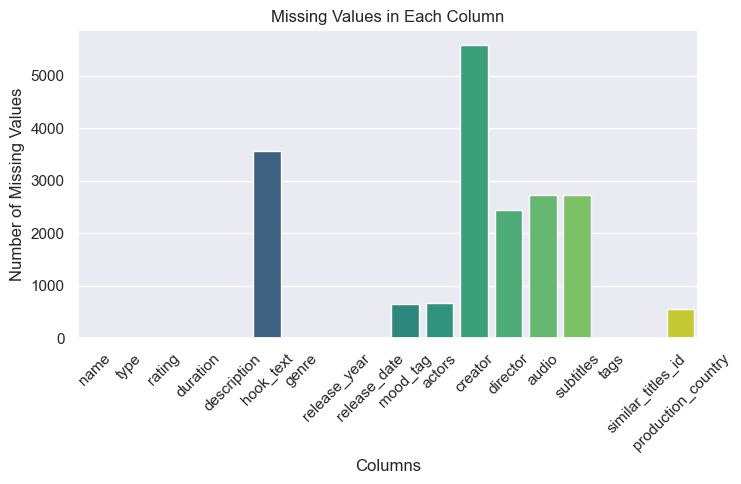

In [69]:
missing_values = df.isnull().sum()
print(missing_values)
plt.figure(figsize=(8, 4))
sns.barplot(x=missing_values.index, y=missing_values.values, palette='viridis')
plt.title('Missing Values in Each Column')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=45)
plt.show()

In [70]:
missing_values = df.isnull().sum()/df.shape[0]*100
print(missing_values)

name                   0.000000
type                   0.000000
rating                 0.000000
duration               0.000000
description            0.000000
hook_text             52.831584
genre                  0.000000
release_year           0.192222
release_date           0.000000
mood_tag               9.625906
actors                 9.951205
creator               82.552122
director              36.241313
audio                 40.218838
subtitles             40.233624
tags                   0.000000
similar_titles_id      0.162650
production_country     8.250776
dtype: float64


# Cleaning Data

## Finding Duplicates

In [71]:
duplicate_values = df.duplicated().sum()
print(duplicate_values)

0


## Identifying Garbage values

In [72]:
for i in df.select_dtypes(include="object").columns:
    print(df[i].value_counts())
    print("***"*10)

name
The Kingdom                3
Animal                     3
Wanted                     3
Wild Dog                   3
Mortal Kombat              2
                          ..
Too Old for Fairy Tales    1
Live is Life               1
Police University          1
Youth of May               1
Goyo: The Boy General      1
Name: count, Length: 6687, dtype: int64
******************************
type
Movie       4049
TVSeries    2714
Name: count, dtype: int64
******************************
rating
U/A 16+    2110
A          1910
U/A 13+    1701
U/A 7+      761
U           281
Name: count, dtype: int64
******************************
duration
1 Season      1924
2 Seasons      411
3 Seasons      170
1.5             91
1.6             84
              ... 
2.9667           1
0.7167           1
21 Seasons       1
3.2167           1
14 Seasons       1
Name: count, Length: 206, dtype: int64
******************************
description
Violently pursued by criminals who insist he's a former gangster,

## Checking missing values

<Axes: ylabel='showid'>

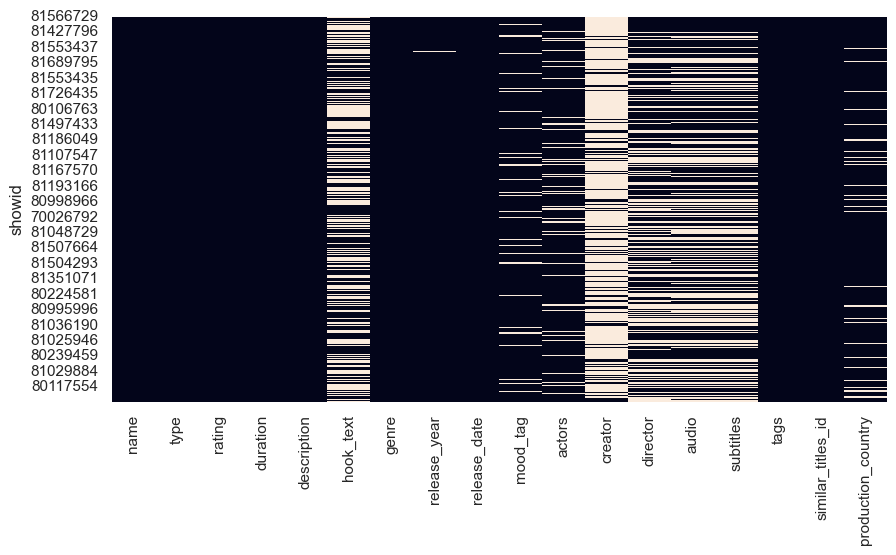

In [73]:
plt.figure(figsize=(10,5))
sns.heatmap(df.isnull(), cbar=False)

## Check unique value

In [74]:
df.nunique()

name                  6687
type                     2
rating                   5
duration               206
description           6624
hook_text             3144
genre                   20
release_year            56
release_date          1858
mood_tag               993
actors                5749
creator               1064
director              3125
audio                  264
subtitles              125
tags                  3505
similar_titles_id     6750
production_country      57
dtype: int64

In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6763 entries, 81566729 to 81031181
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   name                6763 non-null   object        
 1   rating              6763 non-null   object        
 2   duration            6763 non-null   float64       
 3   description         6763 non-null   object        
 4   hook_text           6763 non-null   object        
 5   genre               6763 non-null   object        
 6   release_date        6763 non-null   datetime64[ns]
 7   mood_tag            6763 non-null   object        
 8   actors              6763 non-null   object        
 9   director            6763 non-null   object        
 10  audio               6763 non-null   object        
 11  subtitles           6763 non-null   object        
 12  tags                6763 non-null   object        
 13  similar_titles_id   6763 non-null   object

## Handling missing values

In [75]:
df[['director','mood_tag','actors','hook_text','production_country','subtitles','audio']] = df[['director','mood_tag','actors','hook_text','production_country','subtitles','audio']].fillna('Unknown')
df[['similar_titles_id']] = df[['similar_titles_id']].fillna(-1)
df.drop('creator', axis=1, inplace=True)
df.drop('release_year', axis=1, inplace=True)

In [76]:
df.shape

(6763, 16)

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6763 entries, 81566729 to 81031181
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   name                6763 non-null   object        
 1   rating              6763 non-null   object        
 2   duration            6763 non-null   float64       
 3   description         6763 non-null   object        
 4   hook_text           6763 non-null   object        
 5   genre               6763 non-null   object        
 6   release_date        6763 non-null   datetime64[ns]
 7   mood_tag            6763 non-null   object        
 8   actors              6763 non-null   object        
 9   director            6763 non-null   object        
 10  audio               6763 non-null   object        
 11  subtitles           6763 non-null   object        
 12  tags                6763 non-null   object        
 13  similar_titles_id   6763 non-null   object

## Genre, Director, Mood_Tag, production_country, Subtitles, Audio

In [77]:
# genre
df.genre.value_counts()

genre
Drama               1751
Comedy              1364
Documentary          797
Kids                 651
Action               479
Thriller             360
Romance              358
Anime                287
Reality TV           260
Horror               227
Sci-Fi                89
Fantasy               66
Music                 26
Talk Show             11
Special Interest      10
Variety TV            10
Musical                7
Sports                 5
Western                4
Friendship             1
Name: count, dtype: int64

In [78]:
# director
df.director.value_counts()

director
Unknown                  2451
Suhas Kadav                17
Raúl Campos;Jan Suter      17
Rajiv Chilaka              16
Marcus Raboy               15
                         ... 
Nobutaka Yoda               1
Frank W Chen                1
Shawn Levy                  1
Kensaku Kakimoto            1
Jerrold Tarog               1
Name: count, Length: 3126, dtype: int64

In [79]:
# mood_tag
df.mood_tag.value_counts()

mood_tag
Unknown                          651
Exciting                         467
Goofy                            176
Suspenseful                      154
Feel-Good                        150
                                ... 
Offbeat;Goofy                      1
Charming;Understated;Romantic      1
Provocative;Understated            1
Offbeat;Witty;Suspenseful          1
Absurd;Witty;Quirky                1
Name: count, Length: 994, dtype: int64

In [80]:
#production_country
df.production_country.value_counts()

production_country
United States           1929
India                    872
Unknown                  558
Japan                    480
South Korea              404
United Kingdom           267
Spain                    206
Mexico                   148
Africa                   147
France                   128
China                    123
Canada                   111
Brazil                   101
Germany                   86
Indonesia                 86
Turkey                    79
Italy                     77
South Africa              76
Taiwan                    75
Poland                    69
Egypt                     69
Australia                 67
Thailand                  65
Philippines               61
Colombia                  47
Argentina                 44
Scandinavia               37
Malaysia                  34
Singapore                 27
Saudi Arabia              25
Middle East               25
Norway                    23
Netherlands               22
Vietnam                 

In [81]:
# Subtitles
df.subtitles.value_counts()

subtitles
Unknown                            2721
English                            2094
English;Hindi                       634
English;English;Hindi               139
English;Japanese                     91
                                   ... 
English;Hindi;Turkish                 1
English;English;Turkish;Turkish       1
English;Hindi;Malayalam               1
English;English;English               1
Arabic;English;English                1
Name: count, Length: 126, dtype: int64

In [82]:
# audio
df.audio.value_counts()

audio
Unknown                                                                    2720
English - Audio Description;English [Original]                              684
English - Audio Description;English [Original];Hindi                        513
English [Original]                                                          444
Hindi [Original]                                                            278
                                                                           ... 
Arabic (Egypt)                                                                1
Hausa [Original]                                                              1
English;French - Audio Description;French [Original];Hindi;Tamil;Telugu       1
Hindi;Tamil [Original]                                                        1
English - Audio Description;Ukrainian [Original]                              1
Name: count, Length: 265, dtype: int64

In [83]:
#tags
df.tags.value_counts()

tags
Stand-Up Comedy                                                               243
Kids' TV;TV Cartoons                                                           53
Romantic Comedies;Comedy Movies;Romantic Movies;US Movies                      50
Family Features;Children & Family Movies;Comedy Movies;US Movies               38
Kids' TV;TV Comedies;TV Cartoons                                               36
                                                                             ... 
Sitcoms;Canadian;TV Comedies;Crime TV Shows                                     1
Canadian;Comedy Movies;TV Comedies                                              1
Romantic TV Dramas;TV Dramas;Thai;TV Shows Based on Books;Fantasy TV Shows      1
Spanish;Docuseries;Social & Cultural Docs                                       1
Filipino;Military Movies;Dramas;Period Pieces;Movies Based on Real Life         1
Name: count, Length: 3505, dtype: int64

In [84]:
# Define a function to apply the split operation only to strings
def split_string(x):
    if isinstance(x, str):
        return x.split(',')[0]  # Splitting the string and taking the first part
    else:
        return np.nan  # If it's not a string, return NaN

# Applying the function to the DataFrame columns
df['audio'] = df['audio'].apply(split_string)
df['subtitles'] = df['subtitles'].apply(split_string)
df['mood_tag'] = df['mood_tag'].apply(split_string)
df['tags'] = df['tags'].apply(split_string)

In [85]:
# Define a function to split string values and handle non-string values
def split_string(x):
    if isinstance(x, str):
        return x.split(',')
    else:
        return [np.nan] if not pd.isnull(x) else []

# Split tags with multiple values
directors_split = df['director'].apply(split_string)

# Use MultiLabelBinarizer for one-hot encoding
mlb = MultiLabelBinarizer()
encoded_directors = pd.DataFrame(mlb.fit_transform(directors_split), columns=mlb.classes_)

## Typecasting 'release_date' from string to datetime

In [103]:
# Typecasting release_date from string to datetime
df["release_date"] = pd.to_datetime(df['release_date'])

In [104]:
# first and last date on which a show was added on Netflix
df.release_date.min(),df.release_date.max()

(Timestamp('1970-01-01 00:00:00'), Timestamp('2024-03-04 00:00:00'))

In [105]:
# create seperate column for year, month, and day
df['month'] = df['release_date'].dt.month
df['year'] = df['release_date'].dt.year
df['day'] = df['release_date'].dt.day

df['day_of_week'] = df['release_date'].dt.dayofweek
df['weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

## Typecasting 'duration' from string to integer

In [116]:
# Convert duration column to string type
df['duration'] = df['duration'].astype(str)

# Extract numerical values from the string and convert to float
df['duration'] = df['duration'].str.extract('(\d+\.?\d*)').astype(float)


In [118]:
# Fit and transform the 'genre' column
df["genre_encoded"] = label_encoder.fit_transform(df["genre"])

In [119]:
selected_columns = ['description','month','year','day', 'day_of_week','weekend','rating_encoded','genre_encoded' ]

# Create a new DataFrame with only the selected columns
df_trans = df[selected_columns].copy()

In [120]:
df_trans.head()

,description,month,year,day,day_of_week,weekend,rating_encoded,genre_encoded
showid,,,,,,,,
81566729,Six young hopefuls at the Hot Wheels Ultimate ...,3,2024,4,0,0,4,8
81739957,It’s the legend vs. the prodigy as Rafael Nada...,3,2024,3,6,1,4,15
81407092,"Through key testimonies, this documentary look...",3,2024,1,4,0,3,3
81746263,Upon discovering he's only Taiwan's third-most...,3,2024,1,4,0,0,4
81301595,"Six months into a solo mission, a lonely astro...",3,2024,1,4,0,3,13


In [130]:
df_trans.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6763 entries, 81566729 to 81031181
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   description     6763 non-null   object
 1   month           6763 non-null   int32 
 2   year            6763 non-null   int32 
 3   day             6763 non-null   int32 
 4   day_of_week     6763 non-null   int32 
 5   weekend         6763 non-null   int64 
 6   rating_encoded  6763 non-null   int64 
 7   genre_encoded   6763 non-null   int64 
dtypes: int32(4), int64(3), object(1)
memory usage: 369.9+ KB


## Ratings

<Axes: xlabel='rating', ylabel='count'>

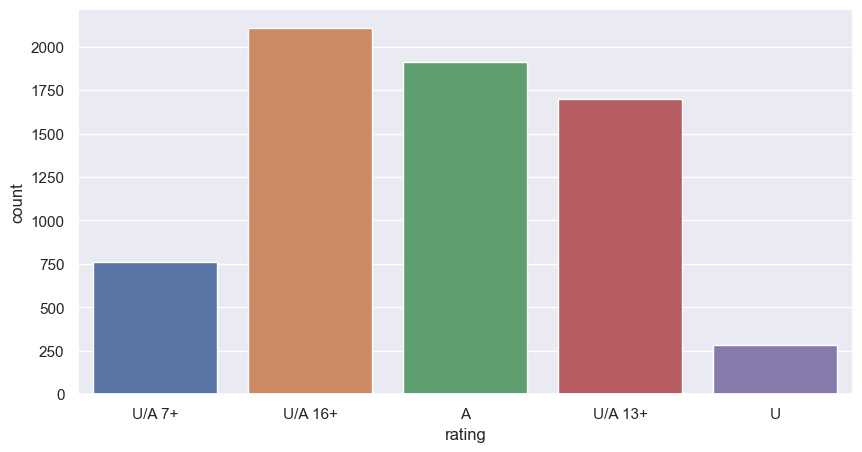

In [89]:
# Age ratings for shows in the dataset
plt.figure(figsize=(10,5))
sns.countplot(x='rating',data=df)

In [90]:
df.rating.unique()

array(['U/A 7+', 'U/A 16+', 'A', 'U/A 13+', 'U'], dtype=object)

In [91]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'rating' column
df["rating_encoded"] = label_encoder.fit_transform(df["rating"])
     

In [92]:
#one hot encoding
dummies=pd.get_dummies(df.type)

df = pd.concat([df,dummies],axis=1)

df.drop('type',axis=1,inplace=True)

In [101]:
df[df['year']==2024]

,name,rating,duration,description,hook_text,genre,release_date,mood_tag,actors,director,...,similar_titles_id,production_country,month,year,day,day_of_week,weekend,rating_encoded,Movie,TVSeries
showid,,,,,,,,,,,,,,,,,,,,,
81566729,Hot Wheels Let's Race,U/A 7+,1.0000,Six young hopefuls at the Hot Wheels Ultimate ...,Unknown,Kids,2024-03-04,Adrenaline Rush;Exciting,Griffin Campbell;Grey DeLisle;Eric Bauza;Jakar...,Unknown,...,81121910;80225085;81480111;81280732;80027979;8...,Unknown,3,2024,4,0,0,4,False,True
81739957,The Netflix Slam,U/A 7+,2.6833,It’s the legend vs. the prodigy as Rafael Nada...,"Play-by-play and commentary by Andre Agassi, A...",Sports,2024-03-03,Feel-Good;Exciting,Rafael Nadal;Carlos Alcaraz;Andre Agassi;Andy ...,Unknown,...,81569920;81026434;81025735;81128594;80204890;8...,United States,3,2024,3,6,1,4,True,False
81407092,You Are Not Alone: Fighting the Wolf Pack,U/A 16+,1.7000,"Through key testimonies, this documentary look...",Unknown,Documentary,2024-03-01,Unknown,Unknown,Almudena Carracedo;Robert Bahar,...,81150989;81168725;80215139;81637286;81667933;8...,Spain,3,2024,1,4,0,3,True,False
81746263,"The Pig, the Snake and the Pigeon",A,2.2333,Upon discovering he's only Taiwan's third-most...,Unknown,Drama,2024-03-01,Emotional,Ethan Juan;Ben Yuen;Chen Yi-wen;Gingle Wang;Hs...,Wong Ching-po,...,81616524;81735590;81639031;81480217;81669979;8...,Taiwan,3,2024,1,4,0,0,True,False
81301595,Spaceman,U/A 16+,1.8000,"Six months into a solo mission, a lonely astro...",Adam Sandler stars with Oscar nominee Carey Mu...,Sci-Fi,2024-03-01,Mind-Bending;Cerebral;Psychological,Adam Sandler;Carey Mulligan;Paul Dano;Kunal Na...,Johan Renck,...,81199139;81735590;81480217;81480320;80237957;8...,United States,3,2024,1,4,0,3,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81746611,Sengoku Youko,U/A 16+,1.0000,"A fox spirit girl, her mystic brother and a co...",Unknown,Anime,2024-01-10,Exciting,Soma Saito;Yuuki Takada;Ryohei Kimura;Tomoyo K...,Unknown,...,81736316;81564899;81436990;81746882;70309073;8...,Japan,1,2024,10,2,0,3,False,True
81740314,Mantra Surugana,A,1.6333,"Arriving in her new dormitory, Tantri soon dis...",Unknown,Horror,2024-01-10,Scary,Sitha Marino;Fergie Brittany;Luna Shabrina;Cin...,Dyan Sunu Prastowo,...,81725776;81704206;81675814;81691510;70215455;8...,Indonesia,1,2024,10,2,0,0,True,False
81588093,Fool Me Once,U/A 16+,1.0000,When ex-soldier Maya sees her murdered husband...,This adaptation of Harlan Coben's bestseller s...,Thriller,2024-01-01,Psychological;Suspenseful,Michelle Keegan;Adeel Akhtar;Richard Armitage;...,Unknown,...,80123729;81335264;81150793;81289581;81332052;8...,United Kingdom,1,2024,1,0,0,3,False,True


# Exploratory Data Analysis

## Univariant Analysis

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6763 entries, 81566729 to 81031181
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   name                6763 non-null   object        
 1   rating              6763 non-null   object        
 2   duration            6763 non-null   float64       
 3   description         6763 non-null   object        
 4   hook_text           6763 non-null   object        
 5   genre               6763 non-null   object        
 6   release_date        6763 non-null   datetime64[ns]
 7   mood_tag            6763 non-null   object        
 8   actors              6763 non-null   object        
 9   director            6763 non-null   object        
 10  audio               6763 non-null   object        
 11  subtitles           6763 non-null   object        
 12  tags                6763 non-null   object        
 13  similar_titles_id   6763 non-null   object

Text(0.5, 1.0, 'Rating in the dataset')

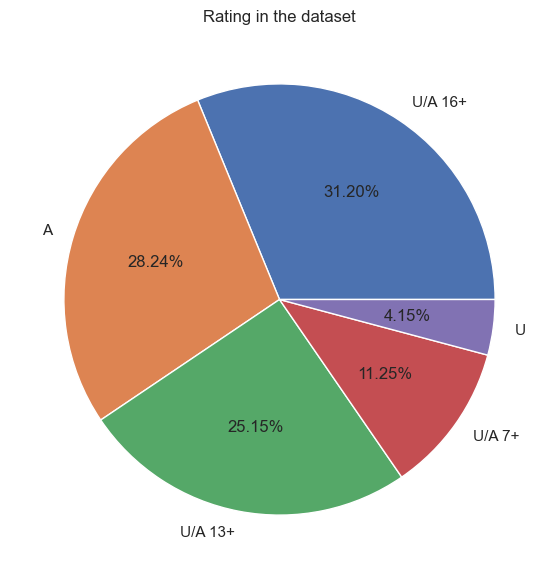

In [135]:
# Number of Rating in the dataset
plt.figure(figsize=(7,7))
df.rating.value_counts().plot(kind='pie',autopct='%1.2f%%')
plt.ylabel('')
plt.title('Rating in the dataset')

Text(0.5, 1.0, 'Top 10 directors by number of shows directed')

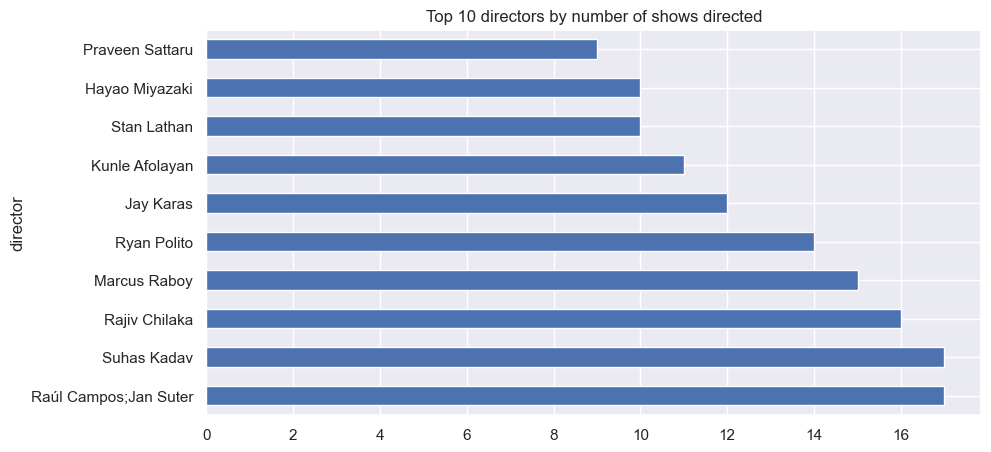

In [124]:
# Top 10 directors in the dataset
plt.figure(figsize=(10,5))
df[~(df['director']=='Unknown')].director.value_counts().nlargest(10).plot(kind='barh')
plt.title('Top 10 directors by number of shows directed')

Text(0.5, 1.0, ' Top 10 countries with the highest number of shows')

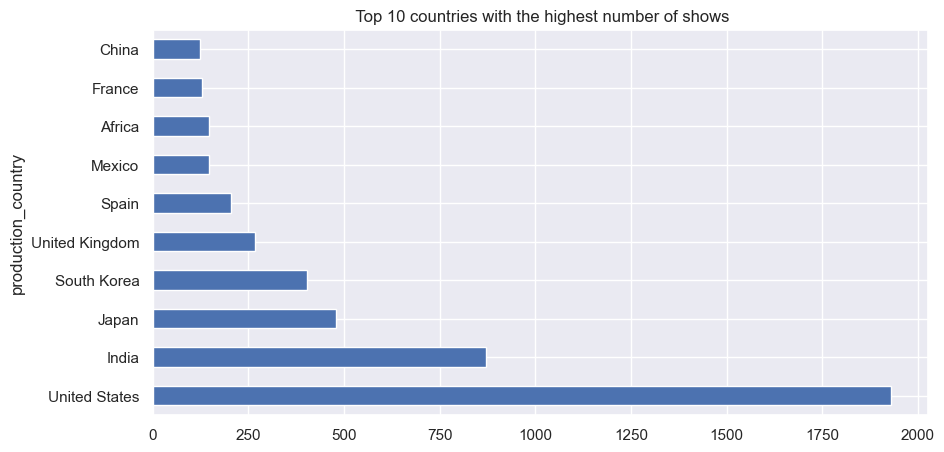

In [125]:
# Top 10 countries with the highest number movies / TV shows in the dataset
plt.figure(figsize=(10,5))
df[~(df['production_country']=='Unknown')].production_country.value_counts().nlargest(10).plot(kind='barh')
plt.title(' Top 10 countries with the highest number of shows')

Text(0.5, 1.0, 'distribution by released year')

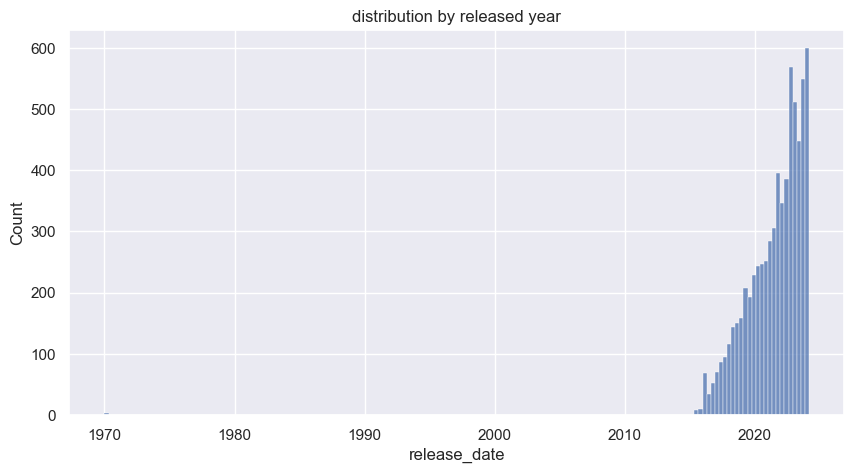

In [133]:
# Visualizing the year in which the movie / tv show was released
plt.figure(figsize=(10,5))
sns.histplot(df['release_date'])
plt.title('distribution by released year')

Text(0.5, 1.0, 'Top 10 genres')

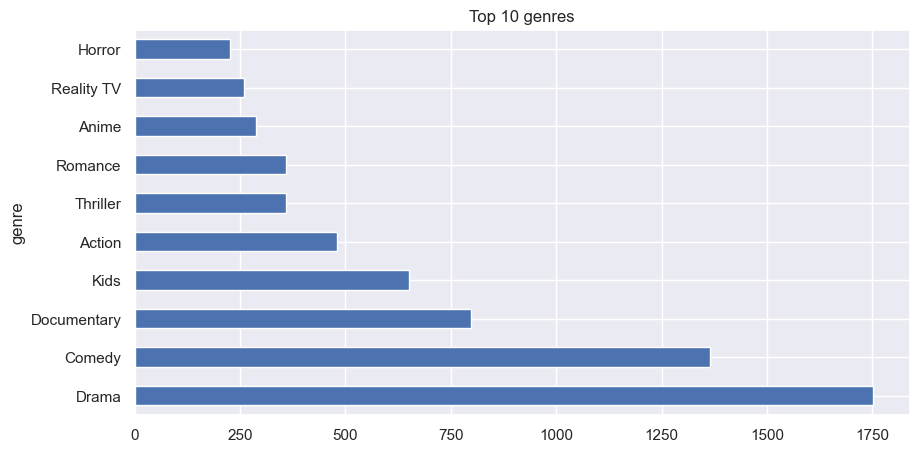

In [136]:
# Top 10 genres 
plt.figure(figsize=(10,5))
df.genre.value_counts().nlargest(10).plot(kind='barh')
plt.title('Top 10 genres')

In [137]:
# Share of top 3 genres
df.genre.value_counts().nlargest(3).sum()/len(df)*100

57.84415200354872

In [138]:
# first and last date on which a show was added on Netflix
df.release_date.min(),df.release_date.max()

(Timestamp('1970-01-01 00:00:00'), Timestamp('2024-03-04 00:00:00'))

In [139]:
# % share of movies / tv shows by top 10 countries
df.production_country.value_counts().nlargest(10).sum()/len(df)*100

75.98698802306669

In [140]:
# % share of movies / tv shows by top 3 countries
df.production_country.value_counts().nlargest(3).sum()/len(df)*100

49.66730740795505

## Bivariate analysis

In [157]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/arushanaganesh/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [160]:
pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 362.9 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


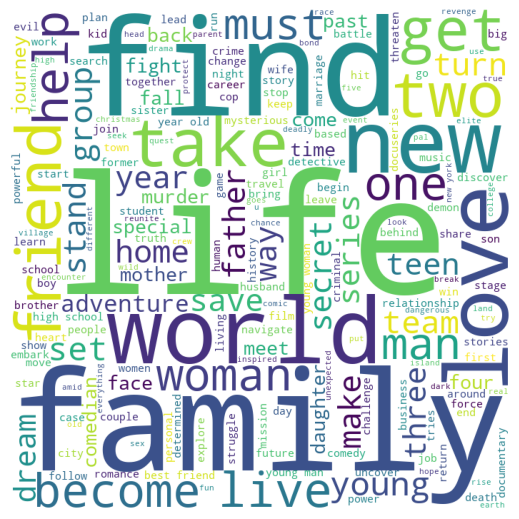

In [163]:
# Load English stopwords
stopwords = set(stopwords.words('english'))

# Building a wordcloud for the movie descriptions
comment_words = ''

# iterate through the csv file
for val in df.description.values:
    
    # typecast each val to string
    val = str(val)

    # split the value
    tokens = val.split()
    
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 700, height = 700,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)


# plot the WordCloud image                      
plt.figure(figsize = (10,5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6763 entries, 81566729 to 81031181
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   name                6763 non-null   object        
 1   rating              6763 non-null   object        
 2   duration            6763 non-null   float64       
 3   description         6763 non-null   object        
 4   hook_text           6763 non-null   object        
 5   genre               6763 non-null   object        
 6   release_date        6763 non-null   datetime64[ns]
 7   mood_tag            6763 non-null   object        
 8   actors              6763 non-null   object        
 9   director            6763 non-null   object        
 10  audio               6763 non-null   object        
 11  subtitles           6763 non-null   object        
 12  tags                6763 non-null   object        
 13  similar_titles_id   6763 non-null   object

Text(0.5, 1.0, 'Top 10 genres for movies')

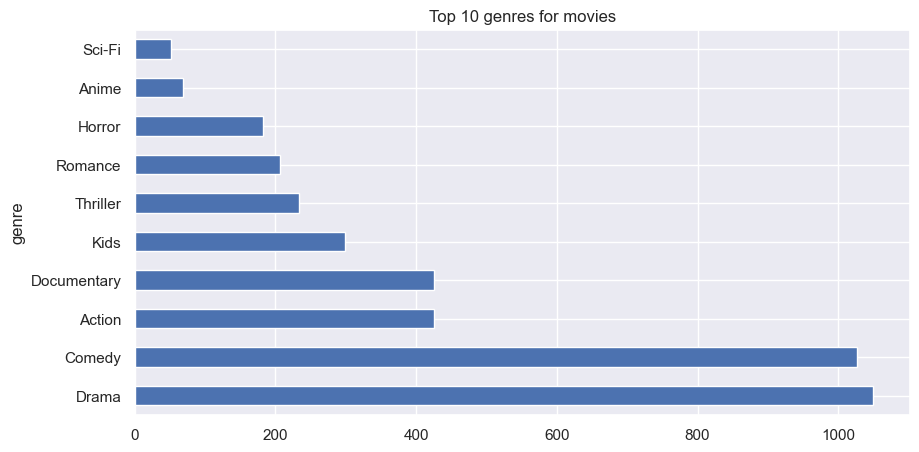

In [207]:
# Top 10 genre for movies
plt.figure(figsize=(10,5))
df[df_new['type']=='Movie'].genre.value_counts().nlargest(10).plot(kind='barh')
plt.title('Top 10 genres for movies')

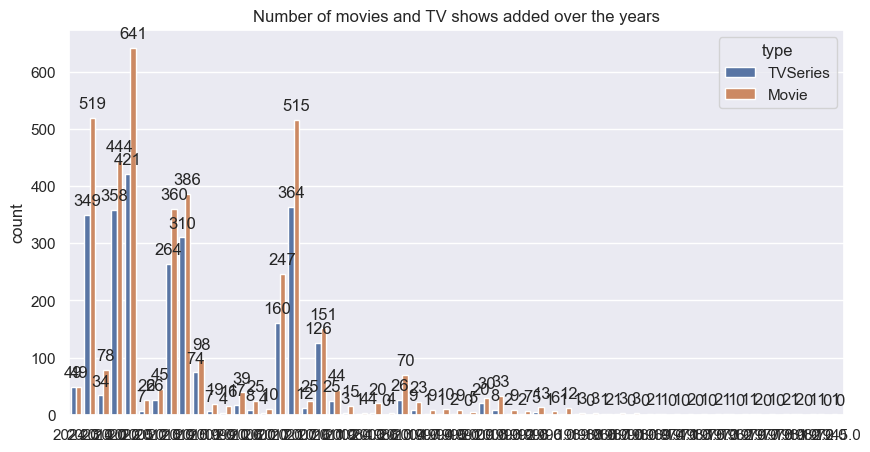

In [211]:
# Number of movies and TV shows added over the years
plt.figure(figsize=(10,5))
p = sns.countplot(x='release_year',data=df_new, hue='type')
plt.title('Number of movies and TV shows added over the years')
plt.xlabel('')
for i in p.patches:
  p.annotate(format(i.get_height(), '.0f'), (i.get_x() + i.get_width() / 2., i.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

Text(0.5, 1.0, 'Movie duration distribution')

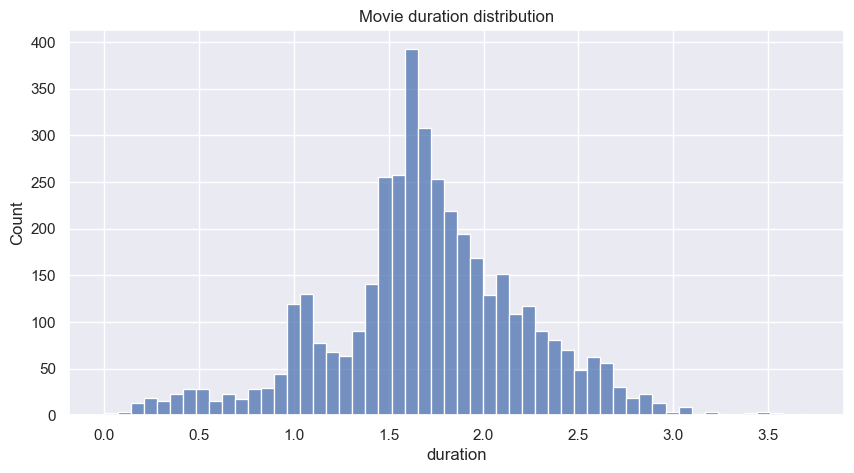

In [212]:
# length of movie analysis
plt.figure(figsize=(10,5))
sns.histplot(x='duration',data=df[df_new['type']=='Movie'])
plt.title('Movie duration distribution')

Text(0.5, 0, 'Year')

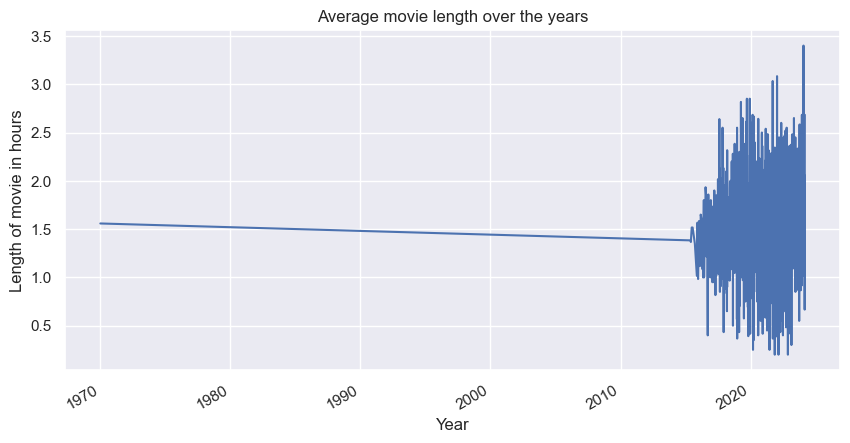

In [219]:
# Average movie length over the years
plt.figure(figsize=(10,5))
df[df_new['type']=='Movie'].groupby('release_date')['duration'].mean().plot(kind='line')
plt.title('Average movie length over the years')
plt.ylabel('Length of movie in hours')
plt.xlabel('Year')

In [215]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6763 entries, 81566729 to 81031181
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   name                   6763 non-null   object
 1   type                   6763 non-null   object
 2   rating                 6763 non-null   object
 3   duration               6763 non-null   object
 4   description            6763 non-null   object
 5   hook_text              6763 non-null   object
 6   genre                  6763 non-null   object
 7   release_year           6763 non-null   object
 8   release_date           6763 non-null   object
 9   mood_tag               6763 non-null   object
 10  actors                 6763 non-null   object
 11  creator                6763 non-null   object
 12  director               6763 non-null   object
 13  audio                  6763 non-null   object
 14  subtitles              6763 non-null   object
 15  tags           

Text(0.5, 1.0, 'Top 10 genres for movies')

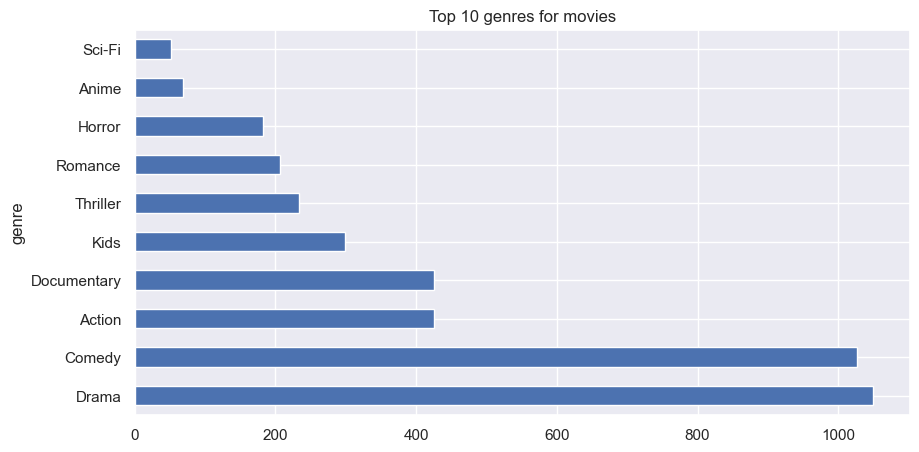

In [220]:
# Top 10 genre for movies
plt.figure(figsize=(10,5))
df[df_new['type']=='Movie'].genre.value_counts().nlargest(10).plot(kind='barh')
plt.title('Top 10 genres for movies')

Text(0.5, 1.0, 'Actors who have appeared in highest number of movies')

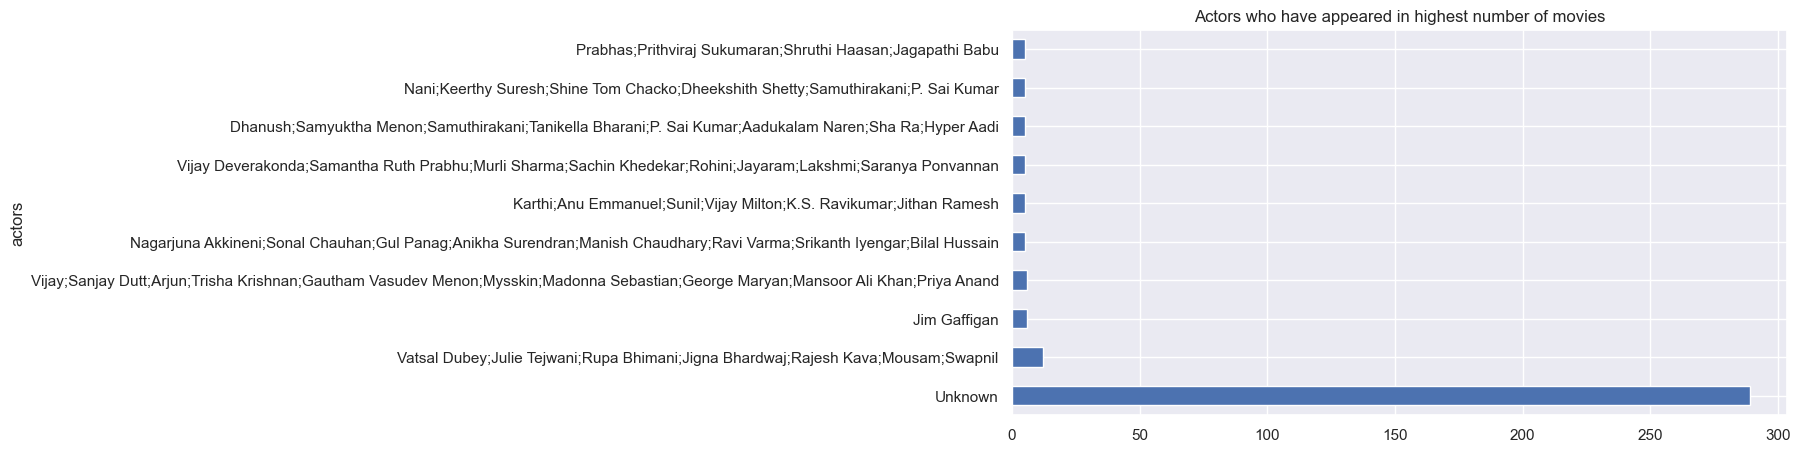

In [222]:
# Top actors for movies
plt.figure(figsize=(10,5))
df[~(df_new['actors']=='Unknown') & (df_new['type']=='Movie')].actors.value_counts().nlargest(10).plot(kind='barh')
plt.title('Actors who have appeared in highest number of movies')

# Data preprocessing

In [177]:
df_new = original_df.copy()

In [178]:
df_new.fillna('',inplace=True)
# Combining all the clustering attributes into a single column

df_new['clustering_attributes'] = (df_new['director'] + ' ' +
                                df_new['hook_text'] +' ' +
                                df_new['production_country'] +' ' +
                                df_new['audio'] +' ' +
                                df_new['subtitles'] +' ' +
                                df_new['tags'] +' ' +
                                df_new['actors'] +' ' +
                                df_new['mood_tag'] +' ' +
                                df_new['description'])

In [176]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6763 entries, 81566729 to 81031181
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   name                6763 non-null   object        
 1   rating              6763 non-null   object        
 2   duration            6763 non-null   float64       
 3   description         6763 non-null   object        
 4   hook_text           6763 non-null   object        
 5   genre               6763 non-null   object        
 6   release_date        6763 non-null   datetime64[ns]
 7   mood_tag            6763 non-null   object        
 8   actors              6763 non-null   object        
 9   director            6763 non-null   object        
 10  audio               6763 non-null   object        
 11  subtitles           6763 non-null   object        
 12  tags                6763 non-null   object        
 13  similar_titles_id   6763 non-null   object

## Remove stopwords and lower case:

In [180]:
# extracting the stopwords from nltk library
import nltk
from nltk.corpus import stopwords
sw = stopwords.words('english')
# displaying the stopwords
np.array(sw)

array(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
       "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself',
       'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her',
       'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
       'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom',
       'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are',
       'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
       'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
       'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',
       'by', 'for', 'with', 'about', 'against', 'between', 'into',
       'through', 'during', 'before', 'after', 'above', 'below', 'to',
       'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
       'again', 'further', 'then', 'once', 'here', 'there', 'when',
       'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'm

In [182]:
# function to remove stop words
def stopwords(text):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)

# Removing stop words
df_new['clustering_attributes'] = df_new['clustering_attributes'].apply(stopwords)

## Remove Punctuation

In [186]:
import string

# function to remove punctuations
def remove_punctuation(text):
    '''a function for removing punctuation'''
    translator = str.maketrans('', '', string.punctuation)
    # return the text stripped of punctuation marks
    return text.translate(translator)

# Removing punctuation marks
df_new['clustering_attributes'] = df_new['clustering_attributes'].apply(remove_punctuation)

In [187]:
# Extracting punctuations
punctuations = string.punctuation
# Displaying the punctuations
punctuations

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

## Lemmatization

In [194]:
from nltk.stem import WordNetLemmatizer

# function to lemmatize the corpus
def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

df_new['clustering_attributes'] = lemmatize_verbs(df_new['clustering_attributes'])

## Vectorization

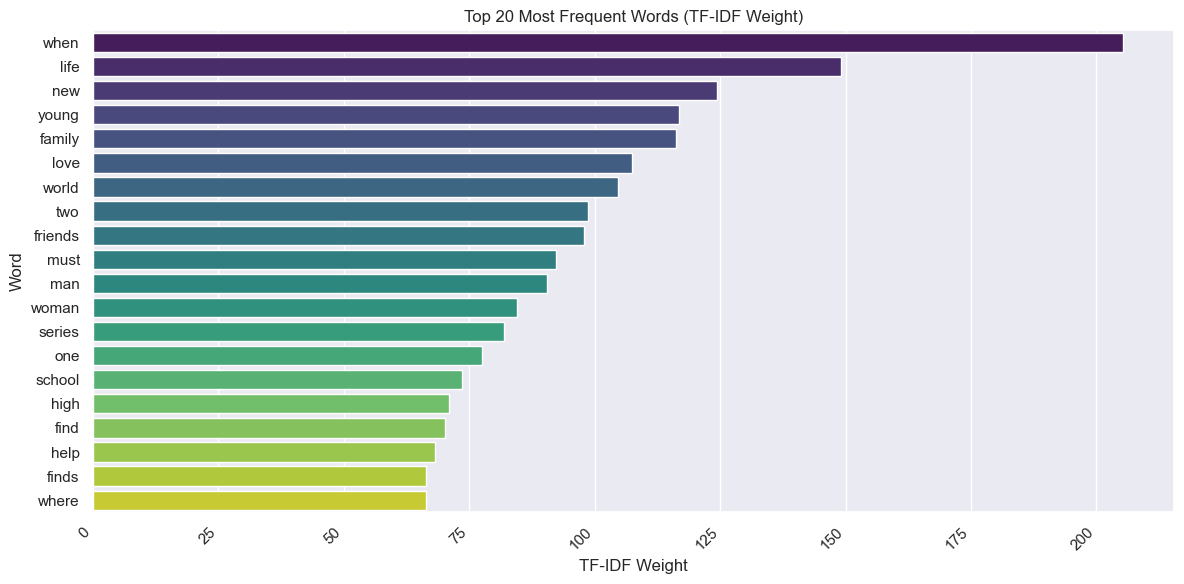

In [231]:
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming your DataFrame 'df' has a column named 'description' containing descriptions
df_new = df[['description']]  # Select the 'description' column for processing

# Text cleaning steps (consider including some common words)
def clean_text(text):
    text = text.lower()  # Lowercase for case-insensitivity
    text = re.sub(r'[^\w\s-]', '', text)  # Remove non-alphanumeric characters and keep hyphens
    # Keep some common words (adjust as needed)
    stop_words = stopwords.words('english')[:100]  # Keep the first 100 most common stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df_new['final_description'] = df_new['description'].apply(clean_text)

# Create TF-IDF vectorizer with a minimum document frequency to handle potentially rare words
tfid_vectorizer = TfidfVectorizer(min_df=2, max_features=1000)  # Adjust parameters as needed

X = tfid_vectorizer.fit_transform(df_text['final_description'])

# Get vocabulary items and corresponding TF-IDF weights
features = tfid_vectorizer.get_feature_names_out()  # Use get_feature_names_out()
weights = X.sum(axis=0).A.ravel()  # Efficiently calculate word weights across all documents

# Create a pandas DataFrame for easier analysis
vocab_count_df = pd.DataFrame({'word': features, 'weight': weights})

# Sort the DataFrame by weight in descending order
vocab_count_df = vocab_count_df.sort_values(by='weight', ascending=False)

# Top 20 most frequent words
top_20_words = vocab_count_df.head(20)

# Create the bar plot with improved formatting using seaborn
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
ax = sns.barplot(x='weight', y='word', data=top_20_words, palette='viridis')  # Use a color palette
ax.set_title('Top 20 Most Frequent Words (TF-IDF Weight)')
ax.set_xlabel('TF-IDF Weight')
ax.set_ylabel('Word')
ax.tick_params(bottom=False)  # Remove unnecessary ticks on the y-axis
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust spacing to prevent overlapping elements
plt.show()

In [203]:
df_new.columns

Index(['name', 'type', 'rating', 'duration', 'description', 'hook_text',
       'genre', 'release_year', 'release_date', 'mood_tag', 'actors',
       'creator', 'director', 'audio', 'subtitles', 'tags',
       'similar_titles_id', 'production_country', 'clustering_attributes'],
      dtype='object')

In [232]:
X
# Shape of X
X.shape
# data type of vector
type(X)
# convert X into array form for clustering
X = X.toarray()

## Dimensionality reduction using PCA

In [236]:
# using PCA to reduce dimensionality
pca = PCA(random_state=42)
pca.fit(X)

PCA(random_state=42)

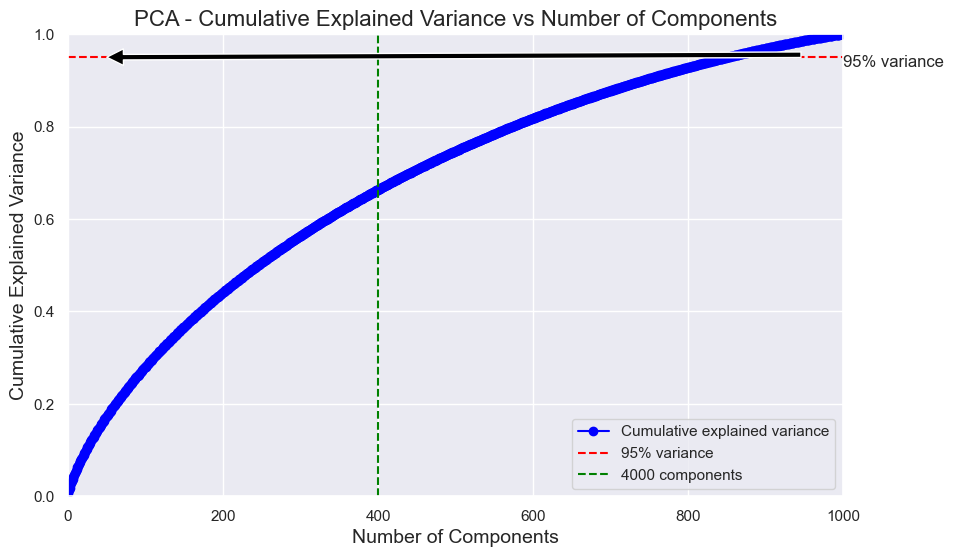

In [255]:
# using PCA to reduce dimensionality
pca = PCA(random_state=42)
pca.fit(X)
# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance vs number of components
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, label='Cumulative explained variance', color='blue', marker='o', linestyle='-')

# Add a horizontal line at 95% variance
plt.axhline(y=0.95, color='red', linestyle='--', label='95% variance')

# Add a vertical line at 4000 components
plt.axvline(x=400, color='green', linestyle='--', label='4000 components')

# Title and labels
plt.title('PCA - Cumulative Explained Variance vs Number of Components', fontsize=16)
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Cumulative Explained Variance', fontsize=14)

# Set x and y axis limits
plt.xlim(0, len(cumulative_variance))
plt.ylim(0, 1)

# Add legend
plt.legend()

# Add grid
plt.grid(True)

# Annotate the 95% variance line
plt.annotate('95% variance', xy=(0, 0.95), xytext=(1000, 0.93),
             arrowprops=dict(facecolor='black', shrink=0.05))

# Annotate the 4000 components line
plt.annotate('4000 components', xy=(4000, 0), xytext=(4000, 0.2),
             arrowprops=dict(facecolor='black', shrink=0.05))

# Show plot
plt.show()


In [260]:
# reducing the dimensions to 400 using pca
pca = PCA(n_components=400,random_state=42)
pca.fit(X)
# transformed features
x_pca = pca.transform(X)
# shape of transformed vectors
x_pca.shape

(6763, 400)

# Clusters implementation

## Agglomerative (hierarchical) clustering algorithm

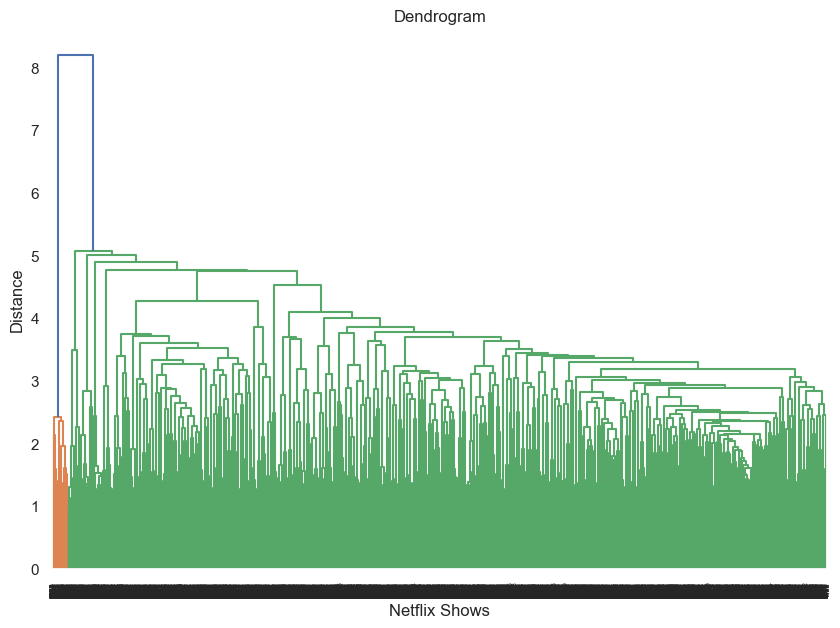

In [263]:
# Building a dendogram to decide on the number of clusters
plt.figure(figsize=(10, 7))
dend = shc.dendrogram(shc.linkage(x_pca, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Netflix Shows')
plt.ylabel('Distance')
plt.axhline(y= 65, color='r', linestyle='--')

In [265]:
# Fitting hierarchical clustering model
hierarchical = AgglomerativeClustering(n_clusters=12, affinity='euclidean', linkage='ward')  
hierarchical.fit_predict(x_pca)

array([ 0,  1,  0, ..., 10,  0,  0])

In [267]:
# Adding a kmeans cluster number attribute
df_new['hierarchical_cluster'] = hierarchical.labels_

In [272]:
from sklearn.metrics import silhouette_score

# Assuming you have already fitted the k-medoids model to the data
silhouette_avg = silhouette_score(x_pca, hierarchical.labels_)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.00037006381065835686


In [276]:
from sklearn.metrics import calinski_harabasz_score
from sklearn.cluster import AgglomerativeClustering

# Assuming preprocessed_features is your preprocessed data
# Example data: 10 samples with 2 features
preprocessed_features = np.random.rand(10, 2)

# Perform hierarchical clustering
hierarchical = AgglomerativeClustering(n_clusters=3)
hierarchical.fit(preprocessed_features)

# Calculate Calinski-Harabasz index
ch_index = calinski_harabasz_score(preprocessed_features, hierarchical.labels_)
print("Calinski-Harabasz Index:", ch_index)


Calinski-Harabasz Index: 15.281917836495822


In [277]:

from sklearn.metrics import davies_bouldin_score

db_index = davies_bouldin_score(preprocessed_features, hierarchical.labels_)
print("Davies-Bouldin Index:", db_index)

Davies-Bouldin Index: 0.6476370849831915


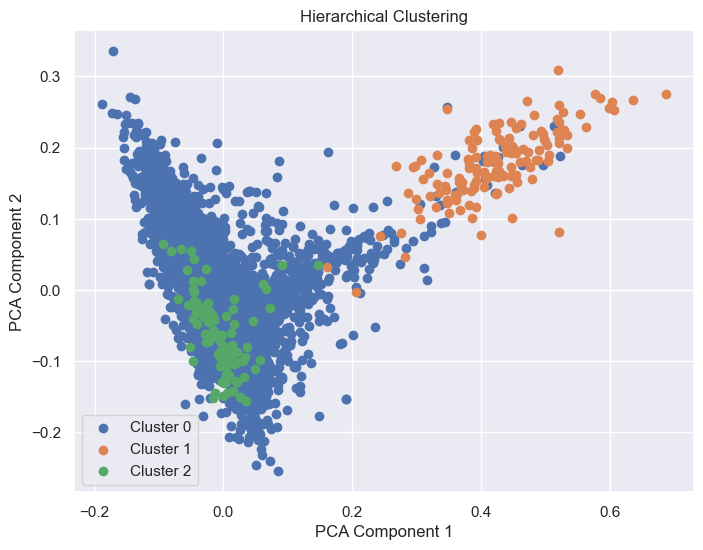

In [280]:
# If hierarchical clustering wasn't fit to x_pca, fit it first:
hierarchical.fit(x_pca)

# Continue with plotting code as provided:
plt.figure(figsize=(8, 6))

# Iterate over each unique cluster label
for cluster_label in set(hierarchical.labels_):
    # Select data points belonging to the current cluster
    cluster_data = x_pca[hierarchical.labels_ == cluster_label]

    # Plot the data points for the current cluster
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster_label}')

# Add labels and title
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Hierarchical Clustering')

# Add legend
plt.legend()

# Show plot
plt.show()


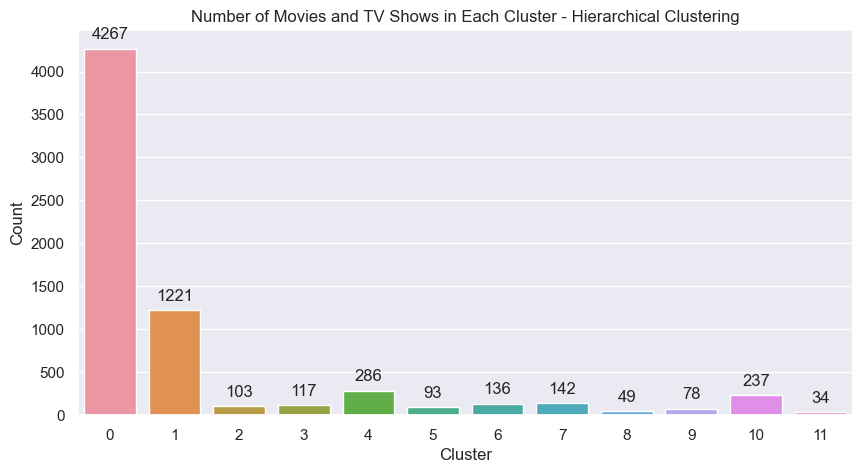

In [326]:
# Set the figure size
plt.figure(figsize=(10, 5))

# Create the countplot
q = sns.countplot(x='hierarchical_cluster', data=df_new)

# Set title and labels
plt.title('Number of Movies and TV Shows in Each Cluster - Hierarchical Clustering')
plt.xlabel('Cluster')
plt.ylabel('Count')

# Add annotations
for i in q.patches:
    q.annotate(format(i.get_height(), '.0f'), (i.get_x() + i.get_width() / 2., i.get_height()), 
               ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Show the plot
plt.show()


## Building wordclouds for different clusters built

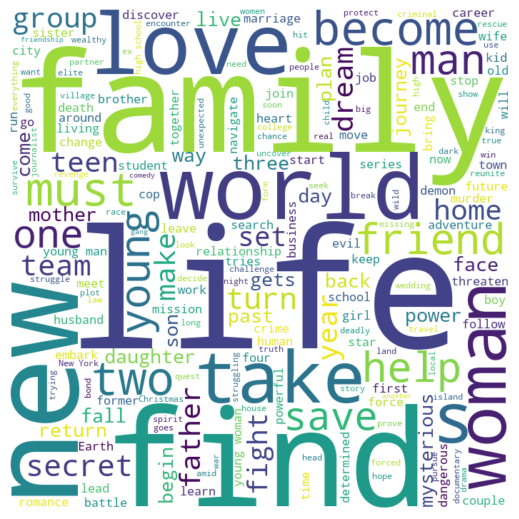

In [327]:
from wordcloud import WordCloud, STOPWORDS  # Import STOPWORDS

def hierarchical_wordcloud(cluster_num, df=df_new, stopwords=None, width=700, height=700, min_font_size=10):
    """
    Generate a word cloud for the descriptions in a specific hierarchical cluster.

    Parameters:
        cluster_num (int): The number of the hierarchical cluster.
        df (DataFrame, optional): The DataFrame containing the data. Default is df1.
        stopwords (set, optional): Set of stopwords to exclude from the word cloud. Default is None.
        width (int, optional): Width of the word cloud image. Default is 700.
        height (int, optional): Height of the word cloud image. Default is 700.
        min_font_size (int, optional): Minimum font size for words in the word cloud. Default is 10.

    Returns:
        None
    """
    # Check if stopwords are provided, otherwise use STOPWORDS from wordcloud
    if stopwords is None:
        stopwords = set(STOPWORDS)

    # Filter the DataFrame for the specified hierarchical cluster
    cluster_df = df_new[df_new['hierarchical_cluster'] == cluster_num]

    # Extract descriptions from the filtered DataFrame
    descriptions = cluster_df['description'].values

    # Combine descriptions into a single string
    comment_words = ' '.join(str(desc) for desc in descriptions)

    # Generate the word cloud
    wordcloud = WordCloud(width=width, height=height, background_color='white',
                          stopwords=stopwords, min_font_size=min_font_size).generate(comment_words)

    # Plot the word cloud
    plt.figure(figsize=(10, 5), facecolor=None)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)

    # Show the plot
    plt.show()

# Generate word cloud for cluster 0
hierarchical_wordcloud(0)


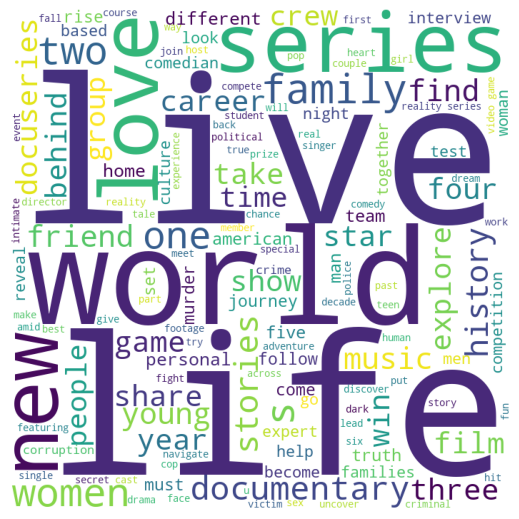

In [328]:
# Wordcloud for cluster 1
hierarchical_worldcloud(1)

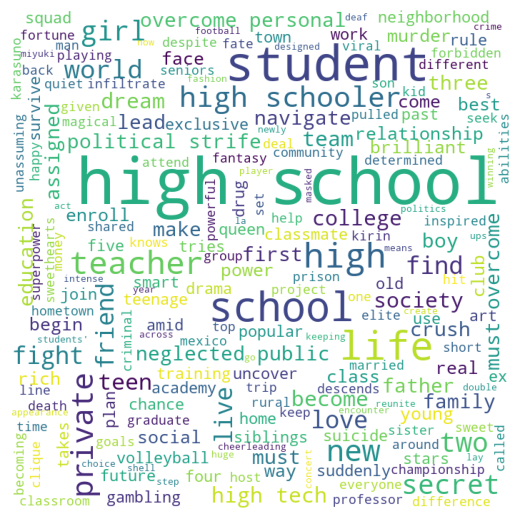

In [329]:
# Wordcloud for cluster 3
hierarchical_worldcloud(3)

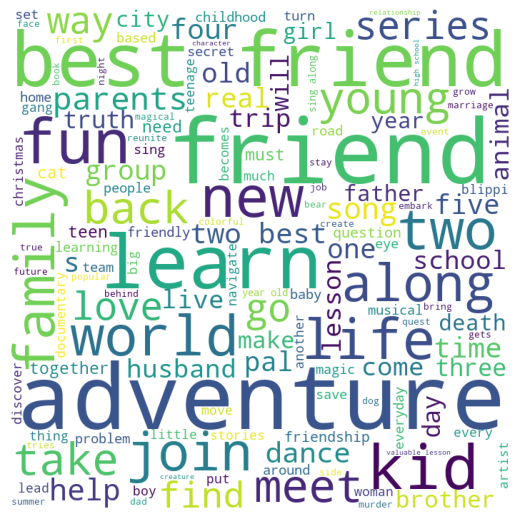

In [330]:
# Wordcloud for cluster 4
hierarchical_worldcloud(4)

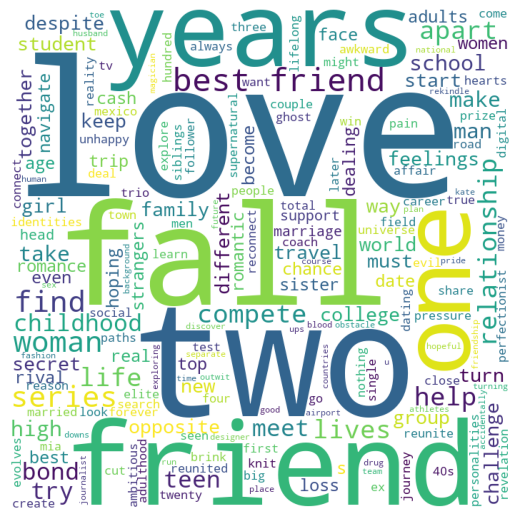

In [331]:
# Wordcloud for cluster 5
hierarchical_worldcloud(5)

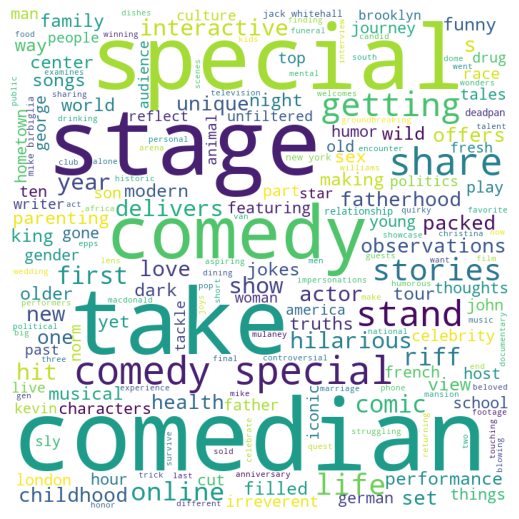

In [332]:
# Wordcloud for cluster 6
hierarchical_worldcloud(6)